#### <a id='top-page'></a>
# `pykitPIV` demo: Learn to locate sources/sinks in a 2D PIV experiment using reinforcement learning

## Single deep convolutional Q-network without memory replay

In this Jupyter notebook, we show how the available functionalities from the machine learning module (`pykitPIV.ml`) can be used to train a reinforcement learning (RL) agent to navigate the virtual PIV camera towards sources/sinks in a radial flow.

We use a **single, convolutional deep Q-learning** agent without memory replay, as implemented in the class [`pykitPIV.ml.CameraAgentSingleDQN`](https://pykitpiv.readthedocs.io/en/latest/user/ml.html#pykitPIV.ml.CameraAgentSingleDQN). 

Note that other RL algorithms are also possible, such as double deep Q-learning with memory replay (see other camera agent classes implemented in the `pykitPIV.ml` module).

The agent can perform one of the five actions:

- Move up
- Move down
- Move right
- Move left
- Stay

on the virtual camera, thereby with each step it moves the virtual PIV camera in 2D by $N$ pixels.

The illustration below shows the single reinforcement learning loop:

<div style="text-align:center;">
    <img src="../docs/images/PIVEnv.svg" style="height:500px">
</div>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#initializations">Initializations</a></li>
    <ul>
        <li><a href="#prepare-specs">Prepare specifications for <code>pykitPIV</code> parameters</a></li>
        <li><a href="#prepare-inference">Prepare the CNN-based inference model for PIV images</a></li>
    </ul>
    <li><a href="#create-env">Create the RL environment</a></li>
    <li><a href="#create-agent">Create and train the RL agent</a></li>
    <ul>
        <li><a href="#visualize-training">Visualize the training metrics and the training progress</a></li>
        <li><a href="#visualize-policy">Visualize the learned policy in the training environment</a></li>
    </ul>
    <li><a href="#test-agent">Test the trained agent in a new environment</a></li>
    <ul>
        <li><a href="#visualize-test">Visualize the learned policy in the test environment</a></li>
        <li><a href="#visualize-trajectory">Visualize one sample trajectory in the test environment</a></li>
    </ul>
</ol>
<p></p>
</div>
<br>

***

In [220]:
from pykitPIV.ml import PIVEnv, CameraAgentSingleDQN, Rewards, Cues, plot_trajectory
from pykitPIV.flowfield import compute_q_criterion, compute_divergence
from pykitPIV import ParticleSpecs, FlowFieldSpecs, MotionSpecs, ImageSpecs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import cmcrameri.cm as cmc
import numpy as np
import onnxruntime
import tensorflow as tf
import pandas as pd
import h5py
import torch
import sys, os
import time
import copy as cp

In [221]:
save_images = False
filename = None

In [222]:
action_colors = cmc.batlow(np.linspace(0, 1, 5))
cmap_actions = ListedColormap(action_colors)

Specify the size of the interrogation window and the buffer size:

In [223]:
interrogation_window_size = (40,40)
interrogation_window_size_buffer = 3

Specify the time separation, $\Delta t$, between two PIV image frames:

In [224]:
time_separation = 2

<a class="anchor" id='initializations'></a>
***

## Initializations

[Go to the top](#top-page)

<a id='prepare-specs'></a>

### Prepare specifications for pykitPIV parameters

[Go to the top](#top-page)

In [225]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=0,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=(1, 1),
distances=(2, 2),
densities=(0.4, 0.4),
diameter_std=0,
min_diameter=0.01,
seeding_mode='random',
dtype=<class 'numpy.float64'>,
random_seed=None)


In [250]:
flowfield_spec = FlowFieldSpecs(size=(200,300),
                                time_separation=time_separation,
                                flowfield_type='radial',
                                radial_epsilon=1e-6,
                                radial_source=True,
                                radial_sigma=20,
                                radial_imposed_source_location=None,
                                displacement=(2, 2))

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 300),
size_buffer=10,
time_separation=2,
random_seed=None,
flowfield_type='radial',
gaussian_filters=(10, 10),
n_gaussian_filter_iter=10,
displacement=(2, 2),
constant_u_magnitude=(1, 4),
constant_v_magnitude=(1, 4),
radial_source=True,
radial_imposed_source_location=None,
radial_sigma=20,
radial_epsilon=1e-06,
directionally_divergent_imposed_origin=(0, 0),
directionally_divergent_directions=['x', 'y', 'both'],
directionally_divergent_sources=[True, False],
taylor_green_k=1,
imposed_origin=(0, 0),
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100,
dtype=<class 'numpy.float64'>)


In [251]:
motion_spec = MotionSpecs(n_steps=10,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
n_steps=10,
particle_loss=(0, 0),
particle_gain=(0, 0),
dtype=<class 'numpy.float64'>,
random_seed=None)


In [252]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=(0.98, 0.98),
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
no_laser_plane=False,
alpha=0.125,
extend_gaussian=1,
covariance_matrix=None,
clip_intensities=True,
normalize_intensities=False,
dtype=<class 'numpy.float64'>)


<a id='prepare-inference'></a>

***

### Prepare the CNN-based inference model for PIV images

[Go to the top](#top-page)

Below we upload the trained LIMA model as the inference model to predict flow targets from PIV images.

Note that the RL agent can also be trained on ground truth, which is a more reliable and faster option for training off-line. However, when connecting RL with real experimentation, we do not have access to ground truth and only an approximation of the true displacement fields are available.

In [253]:
class ONNXmodel:
    
    def __init__(self,
                 onnx_file_path):
        
        self.name = "ONNX"
        self.providers = ['CPUExecutionProvider']
        self.session = onnxruntime.InferenceSession(onnx_file_path, 
                                                    None,
                                                    providers=self.providers)

        self.input_name = self.session.get_inputs()[0].name  
        print('Input Name:', self.input_name)   
 
    def inference(self, x):
        
        output = self.session.run([], {self.input_name:x/np.max(x)})[0] 
      
        return output

    def empty(self):
        
         with torch.no_grad():
            torch.cuda.empty_cache()

In [254]:
model_file = '../docs/data/Lima_L4_PAD_SR2_dyn.onnx'
print("model:", model_file, '  exist:', os.path.exists(model_file))

model: ../docs/data/Lima_L4_PAD_SR2_dyn.onnx   exist: True


In [255]:
lima_inference_model = ONNXmodel(model_file)

Input Name: Input


<a id=create-env></a>

***

## Create the RL environment

[Go to the top](#top-page)

This time, the sensory cues that the agent learns from will be the entire displacement field of shape $(1, 2, H, W)$.

In [256]:
cues_function = None

Initialize the `Gymnasium`-based virtual wind tunnel environment using the `PIVEnv` class:

In [257]:
env = PIVEnv(interrogation_window_size=interrogation_window_size,
             interrogation_window_size_buffer=interrogation_window_size_buffer,
             cues_function=cues_function,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=flowfield_spec,
             user_flowfield=None,
             inference_model=None,
             random_seed=None)

In [258]:
camera_position, cues = env.reset(imposed_camera_position=np.array([40, 20]), regenerate_flowfield=True)

Inspect how many sensory cues this agent will see (these become the inputs to the single deep Q-network):

In [259]:
env.n_cues

2

In [260]:
cues.shape

(1, 2, 40, 40)

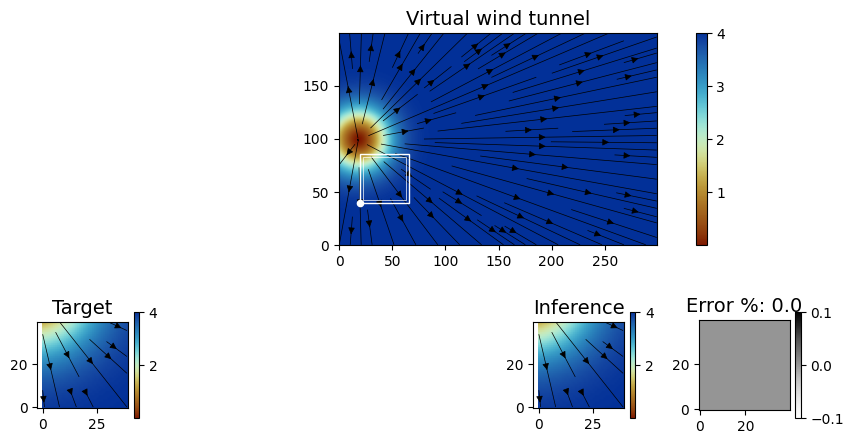

In [261]:
if save_images: filename = 'ml_PIVEnv_render.png'
plt = env.render(quantity=None,
                 camera_position=camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=1,
                 streamplot_color='k',
                 streamplot_linewidth=0.5,
                 figsize=(10,5), 
                 filename=filename)

<a id=create-agent></a>

***

## Create and train the RL agent

[Go to the top](#top-page)

We will train the RL agent on 5000 episodes, where at the beginning of each new episose, a new radial field is generated:

In [19]:
n_episodes = 1000

The number of episodes for logging information about training:

In [20]:
log_every = 50

We will let the RL agent take 20 steps (camera movements) per episode:

In [21]:
n_iterations = 20

Each step will be magnified 10 times, i.e., instead of the step being a movement of camera by 1px, it will be a movement by 10px:

In [22]:
magnify_step = 10

Define the discount factor for the future rewards, $\gamma$:

In [23]:
discount_factor = 0.95

Specify the parameters for the $\varepsilon$-greedy policy:

In [24]:
epsilon_start = 0.5
epsilon_end = 0.2
n_episodes_epsilon_decay = int(9/10 * n_episodes)

Specify the parameters for the learning rate decay:

In [25]:
initial_learning_rate = 0.001
alpha_lr = 0.01
n_episodes_learning_rate_decay = int(9/10 * n_episodes)

Specify the kernel initializer for the weights in the Q-network:

In [26]:
kernel_initializer = tf.keras.initializers.RandomUniform

Specify the gradient descent optimizer to use, it can be `'RMSprop'` or `'Adam'`:

In [27]:
optimizer = 'Adam'

Define the exploration probability decay:

In [28]:
def epsilon_decay(episode, 
                  epsilon_start,
                  epsilon_end,
                  n_decay_steps):
    
    if episode < n_decay_steps:
        return epsilon_start - (episode / n_decay_steps) * (epsilon_start - epsilon_end)
    else:
        return epsilon_end

In [29]:
exploration_probabilities = []

for i in range(0,n_episodes):

    exploration_probabilities.append(epsilon_decay(i, epsilon_start, epsilon_end, n_decay_steps=n_episodes_epsilon_decay))

Inspect how the exploration probability will be decayed over the episodes:

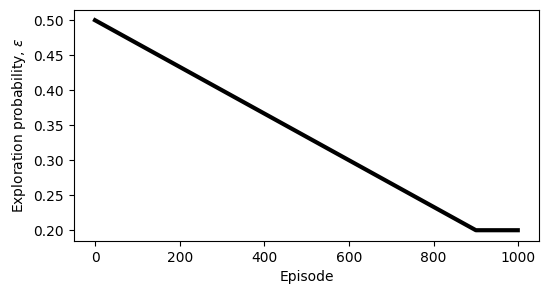

In [30]:
plt.figure(figsize=(6,3))
plt.plot(exploration_probabilities, c='k', lw=3)
plt.xlabel('Episode')
plt.ylabel(r'Exploration probability, $\varepsilon$');

Define the cosine learning rate decay:

In [31]:
def learning_rate_decay(episode, 
                        initial_learning_rate, 
                        alpha_lr, 
                        n_decay_steps):
    
    episode = np.min([episode, n_decay_steps])
    cosine_decay = 0.5 * (1 + np.cos(np.pi * episode / n_decay_steps))
    decayed = (1 - alpha_lr) * cosine_decay + alpha_lr
    
    return initial_learning_rate * decayed

In [32]:
decayed_learning_rates = []

for i in range(0,n_episodes):

    decayed_learning_rates.append(learning_rate_decay(i,
                                                      initial_learning_rate=initial_learning_rate, 
                                                      alpha_lr=alpha_lr, 
                                                      n_decay_steps=n_episodes_learning_rate_decay))

Inspect how the learning rate will be decayed over the episodes:

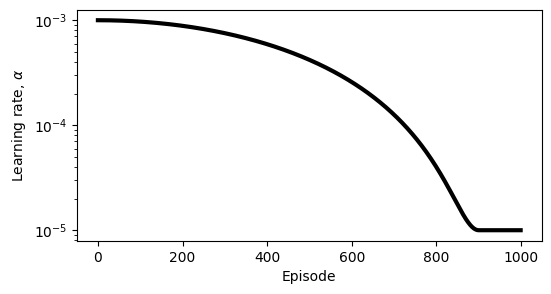

In [33]:
plt.figure(figsize=(6,3))
plt.semilogy(decayed_learning_rates, c='k', lw=3)
plt.xlabel('Episode')
plt.ylabel(r'Learning rate, $\alpha$');

We define the architecture for the deep convolutional Q-network (a convolutional neural network (CNN)):

In [34]:
size_of_hidden_unit = 64
size_of_hidden_unit

64

In [35]:
class ConvQNetwork(tf.keras.Model):
    
    def __init__(self, n_actions, kernel_initializer):
    
        super(ConvQNetwork, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(16, (3, 3), strides=1, activation='relu', kernel_initializer=kernel_initializer)
        
        self.global_max_pool = tf.keras.layers.GlobalMaxPooling2D()

        self.dense1 = tf.keras.layers.Dense(size_of_hidden_unit, activation='relu', kernel_initializer=kernel_initializer)
        self.dense2 = tf.keras.layers.Dense(size_of_hidden_unit, activation='relu', kernel_initializer=kernel_initializer)
        self.output_layer = tf.keras.layers.Dense(n_actions, activation=None, kernel_initializer=kernel_initializer)

    def call(self, inputs):

        x = self.conv1(inputs)
        x = self.global_max_pool(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return self.output_layer(x)

Initialize the camera agent using the `CameraAgentSingleDQN` class:

In [36]:
ca = CameraAgentSingleDQN(env=env,
                          q_network=ConvQNetwork(env.n_actions, kernel_initializer),
                          learning_rate=initial_learning_rate,
                          optimizer=optimizer,
                          discount_factor=discount_factor)

The uploaded environment has 5 actions.


We are going to use the reward based on divergence:

In [37]:
rewards = Rewards(verbose=False)
reward_function = rewards.divergence

Define a transformation function for the reward which is appropriate to detecting regions of high divergence:

In [38]:
def reward_transformation(div): 
    return float(np.mean(np.abs(div)))

Run training of the RL agent. Note that we are regenerating the radial flowfield at the beginning of each episode to present as many unseen scenarios during training as possible. This should help in training and generalization.

In [39]:
total_tic = time.perf_counter()

print()
print('- '*20)
print('Starting training the RL agent...\n')

tic = time.perf_counter()

iter_count = 0

collected_rewards = []
collected_average_rewards = []
collected_logged_episodes = []

current_lr = cp.deepcopy(initial_learning_rate)

batch_q_values_collected = np.zeros((1, env.n_actions))

average_reward = 0.0

for episode in range(0, n_episodes):

    camera_position, cues = ca.env.reset(regenerate_flowfield=True)
    cues = np.transpose(cues, (0, 2, 3, 1))
    cues[:,1,:,:] = -cues[:,1,:,:]
    
    total_reward = 0.0

    # Exploration probability decreases with training time:
    epsilon = epsilon_decay(episode=iter_count, 
                            epsilon_start=epsilon_start,
                            epsilon_end=epsilon_end,
                            n_decay_steps=n_episodes_epsilon_decay)

    # Decay the learning rate:
    current_lr = learning_rate_decay(episode=iter_count, 
                                     initial_learning_rate=initial_learning_rate, 
                                     alpha_lr=alpha_lr, 
                                     n_decay_steps=n_episodes_learning_rate_decay)
    
    iter_count += 1

    if (episode) % log_every == 0:

        print(f'Episode: {episode + 1}')
        print(f'Epsilon: {epsilon:0.3f}')
        print('Learning rate: ' + str(current_lr))

    # In each episode, take a number of iterations in the environment:
    for i in range(0,n_iterations):

        # Select an action:
        action = ca.choose_action(cues,
                                  epsilon=epsilon)

        next_camera_position, next_cues, reward = ca.env.step(action,
                                                              reward_function=reward_function,
                                                              reward_transformation=reward_transformation,
                                                              magnify_step=magnify_step,
                                                              verbose=False)
        
        next_cues = np.transpose(next_cues, (0, 2, 3, 1))
        next_cues[:,1,:,:] = -next_cues[:,1,:,:]
    
        total_reward += reward
        average_reward += reward

        # Train the RL agent with the current step:
        ca.train(cues=cues,
                 action=action,
                 reward=reward,
                 next_cues=next_cues,
                 new_learning_rate=current_lr)

        cues = next_cues
    
    batch_q_values = ca.q_network(cues, training=False).numpy()
    batch_q_values_collected = np.vstack((batch_q_values_collected, batch_q_values))

    if (episode) % log_every == 0:

        toc = time.perf_counter()

        collected_average_rewards.append(average_reward/log_every)
        collected_logged_episodes.append(episode)

        print(f"Average reward: {(average_reward/log_every):0.1f}")
        print(f'These episodes took: {(toc - tic):0.1f} sec.')
        print('- '*15)
        print()

        average_reward = 0.0

        tic = time.perf_counter()

    collected_rewards.append(total_reward)

batch_q_values_collected = batch_q_values_collected[1::,:]

total_toc = time.perf_counter()
print()
print('- '*20)
print(f'Total training time: {(total_toc - total_tic)/60:0.1f} minutes.')


- - - - - - - - - - - - - - - - - - - - 
Starting training the RL agent...

Episode: 1
Epsilon: 0.500
Learning rate: 0.001
Average reward: 0.0
These episodes took: 1.0 sec.
- - - - - - - - - - - - - - - 

Episode: 51
Epsilon: 0.483
Learning rate: 0.000992479837741043
Average reward: 1.0
These episodes took: 46.6 sec.
- - - - - - - - - - - - - - - 

Episode: 101
Epsilon: 0.467
Learning rate: 0.0009701478472890247
Average reward: 1.0
These episodes took: 44.2 sec.
- - - - - - - - - - - - - - - 

Episode: 151
Epsilon: 0.450
Learning rate: 0.0009336825748732972
Average reward: 1.3
These episodes took: 46.0 sec.
- - - - - - - - - - - - - - - 

Episode: 201
Epsilon: 0.433
Learning rate: 0.0008841919993438941
Average reward: 1.2
These episodes took: 46.0 sec.
- - - - - - - - - - - - - - - 

Episode: 251
Epsilon: 0.417
Learning rate: 0.000823179866794837
Average reward: 1.1
These episodes took: 49.6 sec.
- - - - - - - - - - - - - - - 

Episode: 301
Epsilon: 0.400
Learning rate: 0.000752499999

You can view the current weights and biases:

In [40]:
WB = ca.view_weights()

You can also save the current trained deep convolutional Q-network. Go to the end of this Jupyter notebook to learn how to upload the trained deep Q-network in the future.

In [41]:
ca.q_network.save('../docs/data/SingleConvDQN.keras')

#### <a id='visualize-training'></a>

### Visualize the training metrics and the training progress

[Go to the top](#top-page)

Below, we visualize the rewards received across the training episodes. Notice how at the beginning of training low rewards are obtained by the agent most of the time, but the distribution in rewards shifts as the training progresses. Close to the end of training, the agent is able to get the highest rewards most of the time.

(0.0, 1000.0)

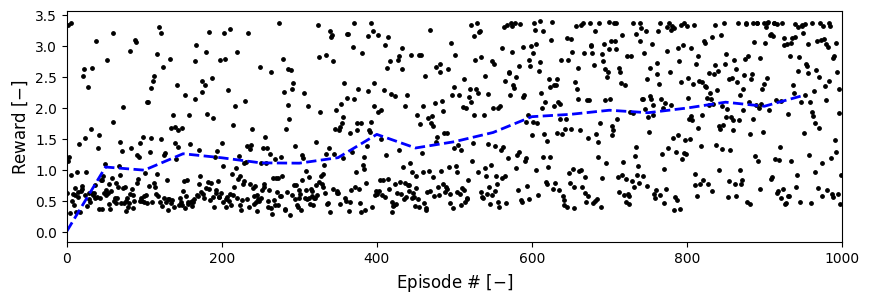

In [42]:
plt.figure(figsize=(10,3))
plt.scatter([i for i in range(0, len(collected_rewards))], collected_rewards, s=6, c='k')
plt.plot(collected_logged_episodes, collected_average_rewards, '--', c='b', lw=2)
plt.ylabel('Reward [$-$]', fontsize=12)
plt.xlabel('Episode # [$-$]', fontsize=12)
plt.xlim([0, n_episodes])

Text(0.5, 0, 'Episode # [$-$]')

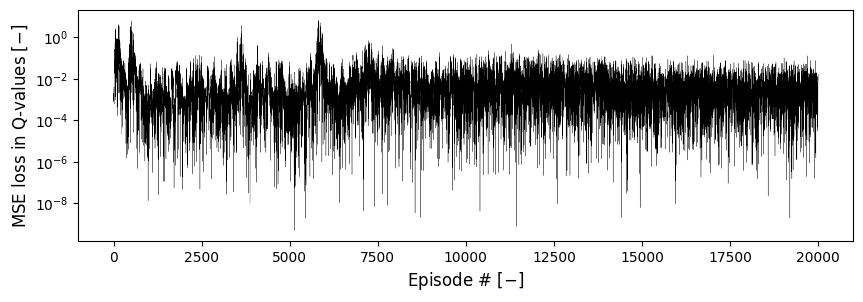

In [43]:
MSE_losses_collected = np.array(ca.MSE_losses).ravel()
plt.figure(figsize=(10,3))
plt.semilogy(MSE_losses_collected, color='k', lw=0.2)
plt.ylabel('MSE loss in Q-values [$-$]', fontsize=12)
plt.xlabel('Episode # [$-$]', fontsize=12)

Text(0, 0.5, 'Q-value')

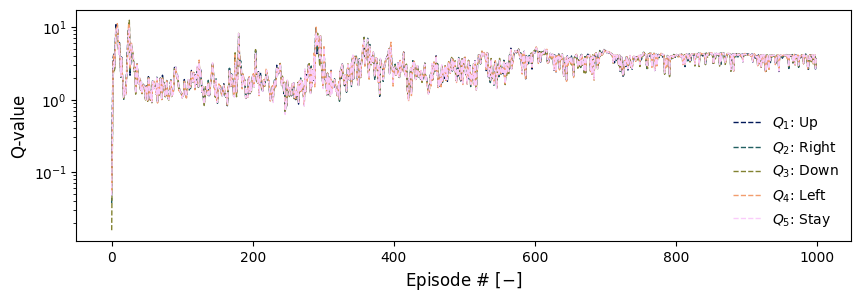

In [44]:
plt.figure(figsize=(10,3))
for i in range(0,env.n_actions):
    plt.semilogy(batch_q_values_collected[:,i], '--', label='$Q_' + str(i+1) + '$: ' + env.action_to_verbose_direction[i], color=action_colors[i], lw=1)
plt.legend(frameon=False)
plt.xlabel('Episode # [$-$]', fontsize=12)
plt.ylabel('Q-value', fontsize=12)

#### <a id='visualize-policy'></a>

### Visualize the learned policy in the training environment

[Go to the top](#top-page)

Create sparse samples of camera position on a uniform grid:

In [45]:
(_, _, H, W) = ca.env.flowfield.velocity_field_magnitude.shape
(H_adm, W_adm) = ca.env.admissible_observation_space
idx_H = [i for i in range(0, H_adm) if i % 1 == 0]
idx_W = [i for i in range(0, W_adm) if i % 1 == 0]
print(len(idx_H) * len(idx_W))

39116


Populate the policy matrix:

In [46]:
tic = time.perf_counter()

learned_policy = np.ones((H,W)) * np.nan

for h in idx_H:
    for w in idx_W:

        camera_position = np.array([h, w])
        _, cues = ca.env.reset(imposed_camera_position=camera_position)

        cues = np.transpose(cues, (0, 2, 3, 1))
        cues[:,1,:,:] = -cues[:,1,:,:]
        
        q_values = ca.q_network(cues, training=False)
        action = np.argmax(q_values)
        learned_policy[h, w] = action

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic):0.1f} sec.')

	Time it took: 200.7 sec.


Below, we visualize the learned policy that is specific to the environment plotted below. The agent has correctly learned the strategy to navigate the virtual camera to center on the source.

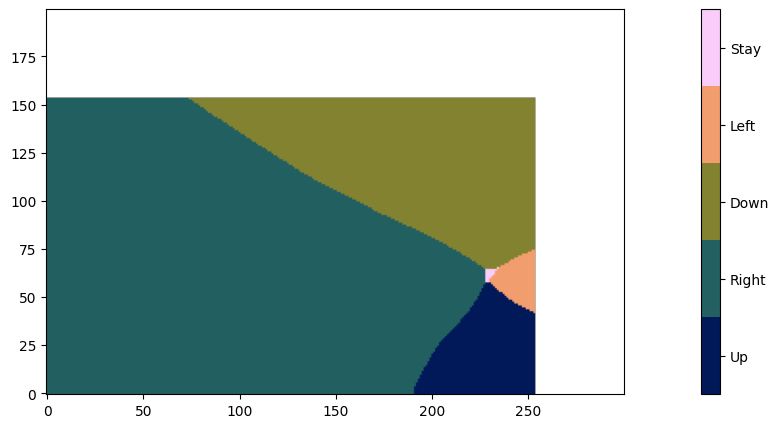

In [47]:
plt.figure(figsize=(20,5))
plt.imshow(learned_policy, origin='lower', cmap=cmap_actions, vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.set_ticks([4/5*(i+0.5) for i in range(0,5)])
cbar.set_ticklabels(list(env.action_to_verbose_direction.values()))

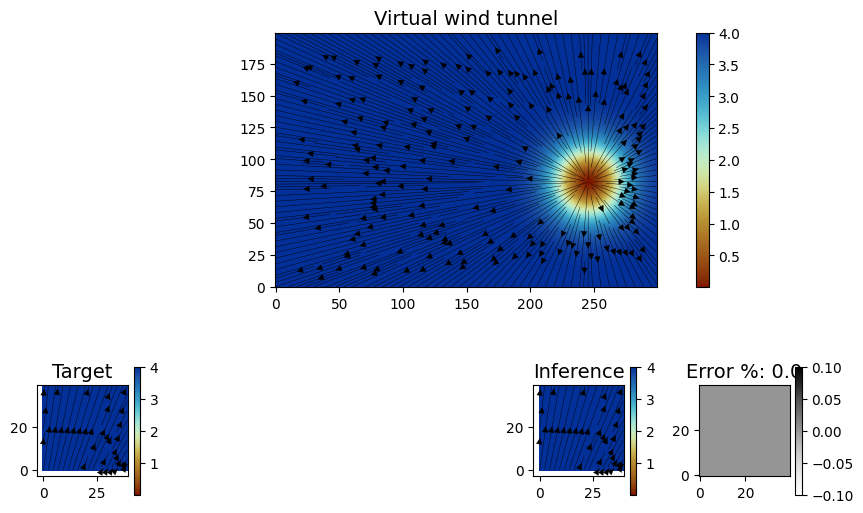

In [48]:
if save_images: filename = 'final-environment.png'
plt = ca.env.render(quantity=None,
                    camera_position=None,
                    c='white',
                    s=20,
                    lw=1,
                    normalize_cbars=True,
                    cmap=cmc.roma,
                    add_streamplot=True,
                    streamplot_density=3,
                    streamplot_color='k',
                    streamplot_linewidth=0.3,
                    figsize=(10,6), 
                    filename=filename);

#### <a id='test-agent'></a>

***

## Test the trained agent in a new environment

[Go to the top](#top-page)

Here, we create a new virtual wind tunnel environment that will allow us to test the learned policy in scenarios where the source can be placed in an arbitrary location.

In [49]:
particle_spec = ParticleSpecs(diameters=1,
                              distances=2,
                              densities=0.4,
                              diameter_std=0,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=1,
distances=2,
densities=0.4,
diameter_std=0,
min_diameter=0.01,
seeding_mode='random',
dtype=<class 'numpy.float64'>,
random_seed=None)


In [50]:
flowfield_spec = FlowFieldSpecs(size=(200,300),
                                time_separation=1,
                                flowfield_type='radial',
                                radial_epsilon=1e-6,
                                radial_source=True,
                                radial_sigma=20,
                                radial_imposed_source_location=None,
                                displacement=(2, 2))

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 300),
size_buffer=10,
time_separation=1,
random_seed=None,
flowfield_type='radial',
gaussian_filters=(10, 10),
n_gaussian_filter_iter=10,
displacement=(2, 2),
constant_u_magnitude=(1, 4),
constant_v_magnitude=(1, 4),
radial_source=True,
radial_imposed_source_location=None,
radial_sigma=20,
radial_epsilon=1e-06,
directionally_divergent_imposed_origin=(0, 0),
directionally_divergent_directions=['x', 'y', 'both'],
directionally_divergent_sources=[True, False],
taylor_green_k=1,
imposed_origin=(0, 0),
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100,
dtype=<class 'numpy.float64'>)


In [51]:
motion_spec = MotionSpecs(n_steps=10,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
n_steps=10,
particle_loss=(0, 0),
particle_gain=(0, 0),
dtype=<class 'numpy.float64'>,
random_seed=None)


In [52]:
image_spec = ImageSpecs(exposures=0.98,
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=0.98,
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
no_laser_plane=False,
alpha=0.125,
extend_gaussian=1,
covariance_matrix=None,
clip_intensities=True,
normalize_intensities=False,
dtype=<class 'numpy.float64'>)


In [53]:
test_env = PIVEnv(interrogation_window_size=interrogation_window_size,
                  interrogation_window_size_buffer=interrogation_window_size_buffer,
                  cues_function=cues_function,
                  particle_spec=particle_spec,
                  motion_spec=motion_spec,
                  image_spec=image_spec,
                  flowfield_spec=flowfield_spec,
                  user_flowfield=None,
                  inference_model=None,
                  random_seed=None)

In [54]:
camera_position, cues = test_env.reset()

In [55]:
camera_position

array([ 57, 148])

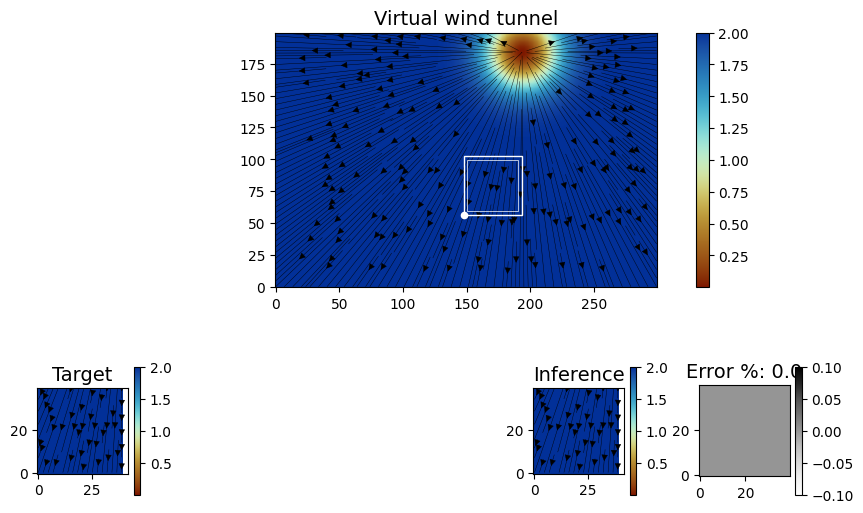

In [56]:
plt = test_env.render(quantity=None,
                      camera_position=camera_position,
                      c='white',
                      s=20,
                      lw=1,
                      normalize_cbars=True,
                      cmap=cmc.roma,
                      add_streamplot=True,
                      streamplot_density=3,
                      streamplot_color='k',
                      streamplot_linewidth=0.3,
                      figsize=(10,6), 
                      filename=None);

In [162]:
divergence = compute_divergence(test_env.flowfield.velocity_field)

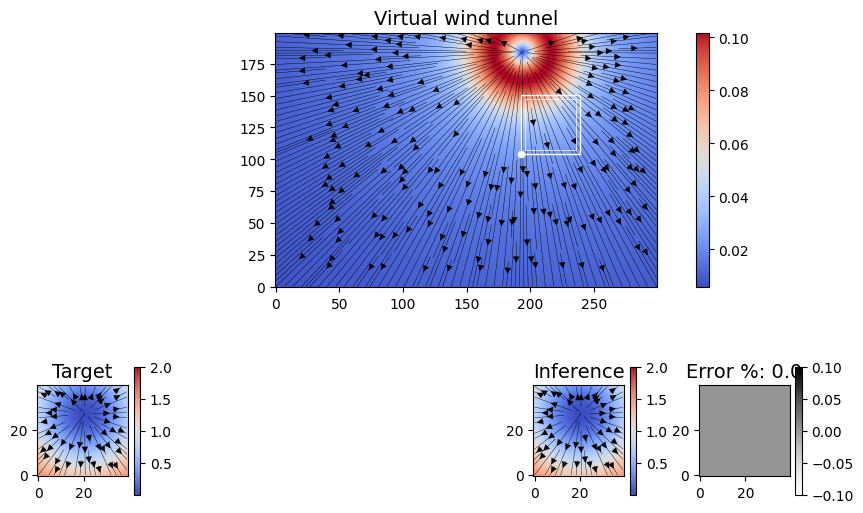

In [165]:
plt = test_env.render(quantity=divergence[0,:,:],
                      camera_position=camera_position,
                      c='white',
                      s=20,
                      lw=1,
                      normalize_cbars=True,
                      cmap='coolwarm',
                      add_streamplot=True,
                      streamplot_density=3,
                      streamplot_color='k',
                      streamplot_linewidth=0.3,
                      figsize=(10,6), 
                      filename=None);

#### <a id='visualize-test'></a>

### Visualize the learned policy in the test environment

[Go to the top](#top-page)

Create sparse samples of camera position on a uniform grid:

In [57]:
(_, _, H, W) = test_env.flowfield.velocity_field_magnitude.shape
(H_adm, W_adm) = test_env.admissible_observation_space
idx_H = [i for i in range(0, H_adm) if i % 1 == 0]
idx_W = [i for i in range(0, W_adm) if i % 1 == 0]
print(len(idx_H) * len(idx_W))

39116


Populate the policy matrix:

In [58]:
tic = time.perf_counter()

learned_policy = np.ones((H,W)) * np.nan

for h in idx_H:
    for w in idx_W:

        camera_position = np.array([h, w])
        _, cues = test_env.reset(imposed_camera_position=camera_position)
        cues = np.transpose(cues, (0, 2, 3, 1))
        cues[:,1,:,:] = -cues[:,1,:,:]
        q_values = ca.q_network(cues, training=False)
        action = np.argmax(q_values)
        learned_policy[h, w] = action

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic):0.1f} sec.')

	Time it took: 195.5 sec.


Below, we visualize the learned policy that is specific to the new test environment plotted above. 
The agent has correctly learned the strategy to navigate the virtual camera to center on the source.

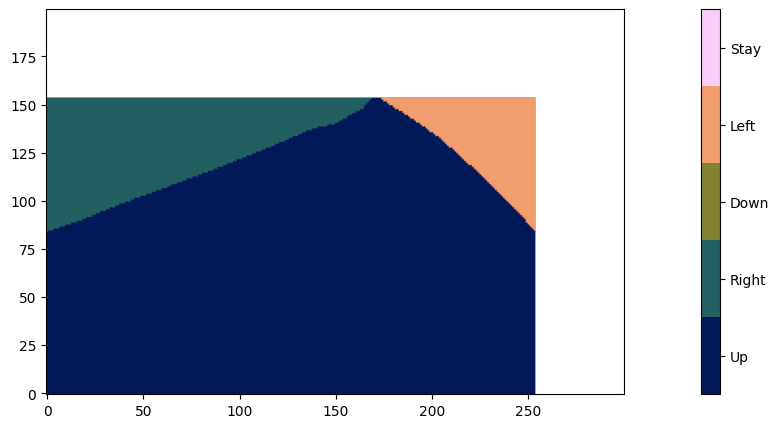

In [59]:
plt.figure(figsize=(20,5))
plt.imshow(learned_policy, origin='lower', cmap=cmap_actions, vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.set_ticks([4/5*(i+0.5) for i in range(0,5)])
cbar.set_ticklabels(list(test_env.action_to_verbose_direction.values()))

#### <a id='visualize-trajectory'></a>

### Visualize one sample trajectory in the test environment

[Go to the top](#top-page)

We are going to take a number of steps in the test environment:

In [60]:
n_steps = 300

In [61]:
saved_camera_trajectories = np.zeros((n_steps,2))

In [62]:
camera_position, cues = test_env.reset(imposed_camera_position=(120,50))

In [63]:
for i in range(0,n_steps):

    cues = np.transpose(cues, (0, 2, 3, 1))
    cues[:,1,:,:] = -cues[:,1,:,:]

    saved_camera_trajectories[i, 0] = camera_position[0]
    saved_camera_trajectories[i, 1] = camera_position[1]

    q_values = ca.q_network(cues, training=False)

    action = np.argmax(q_values)

    print(test_env.action_to_verbose_direction[action])

    camera_position, cues, reward = test_env.step(action=action,
                                                  reward_function=reward_function,
                                                  reward_transformation=reward_transformation,
                                                  magnify_step=2,
                                                  verbose=False)

Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Up
Right
Right
Up
Right
Right
Right
Up
Right
Right
Up
Right
Right
Right
Up
Right
Right
Up
Right
Right
Up
Right
Right
Right
Up
Right
Right
Up
Right
Right
Right
Up
Right
Right
Right
Right
Up
Right
Right
Up
Right
Right
Up
Right
Right
Up
Right
Right
Up
Up
Right
Up
Right
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
U

The figure below visualizes the camera trajectory that results from the learned policy. 
Note that the agent correctly moves the camera towards the region of highest divergence.

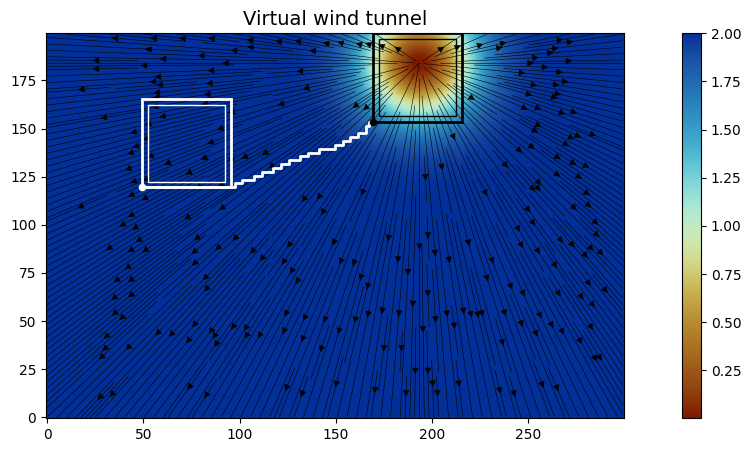

In [64]:
if save_images: filename='test-trajectory.png'
plot_trajectory(saved_camera_trajectories,
                quantity=test_env.flowfield.velocity_field_magnitude[0,0,:,:],
                vector_field=test_env.flowfield.velocity_field,
                interrogation_window_size=interrogation_window_size,
                interrogation_window_size_buffer=interrogation_window_size_buffer,
                c_path='white',
                c_init='white',
                c_final='black',
                s=20,
                lw=2,
                xlabel=None,
                ylabel=None,
                xticks=True,
                yticks=True,
                cmap=cmc.roma,
                add_streamplot=True,
                streamplot_density=4,
                streamplot_color='k',
                streamplot_linewidth=0.4,
                figsize=(15,5),
                dpi=300,
                filename=filename);

<a id='testing-in-new-flow-regimes'></a>

***

## Test the learned policy in new flow regimes

[Go to the top](#top-page)

In [262]:
random_seed = 30

Here, we create a new virtual wind tunnel environment that will allow us to test the learned policy in scenarios where the source can be placed in an arbitrary location.

In [270]:
flowfield_spec = FlowFieldSpecs(size=(200,300),
                                time_separation=1,
                                flowfield_type='directionally divergent',
                                directionally_divergent_directions='x',
                                gaussian_filters=(30, 30),
                                n_gaussian_filter_iter=20,
                                displacement=(4, 4), 
                                random_seed=random_seed)

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 300),
size_buffer=10,
time_separation=1,
random_seed=30,
flowfield_type='directionally divergent',
gaussian_filters=(30, 30),
n_gaussian_filter_iter=20,
displacement=(4, 4),
constant_u_magnitude=(1, 4),
constant_v_magnitude=(1, 4),
radial_source=True,
radial_imposed_source_location=None,
radial_sigma=20,
radial_epsilon=1e-06,
directionally_divergent_imposed_origin=(0, 0),
directionally_divergent_directions=x,
directionally_divergent_sources=[True, False],
taylor_green_k=1,
imposed_origin=(0, 0),
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100,
dtype=<class 'numpy.float64'>)


In [271]:
new_test_env = PIVEnv(interrogation_window_size=interrogation_window_size,
                  interrogation_window_size_buffer=interrogation_window_size_buffer,
                  cues_function=cues_function,
                  particle_spec=particle_spec,
                  motion_spec=motion_spec,
                  image_spec=image_spec,
                  flowfield_spec=flowfield_spec,
                  user_flowfield=None,
                  inference_model=None,
                  random_seed=random_seed)

In [272]:
camera_position, cues = new_test_env.reset()

In [273]:
camera_position

array([67, 13])

In [274]:
divergence = compute_divergence(new_test_env.flowfield.velocity_field)

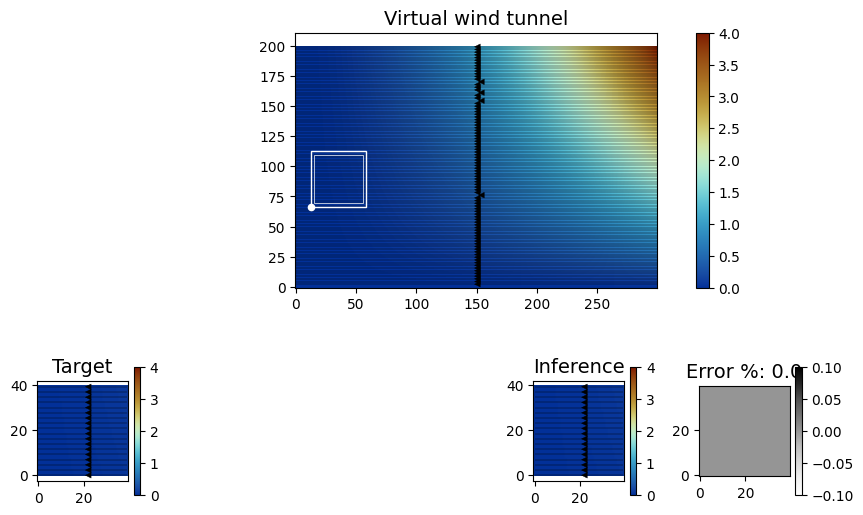

In [275]:
plt = new_test_env.render(quantity=None,
                          camera_position=camera_position,
                          c='white',
                          s=20,
                          lw=1,
                          normalize_cbars=True,
                          cmap=cmc.roma_r,
                          add_streamplot=True,
                          streamplot_density=3,
                          streamplot_color='k',
                          streamplot_linewidth=0.3,
                          figsize=(10,6), 
                          filename=None);

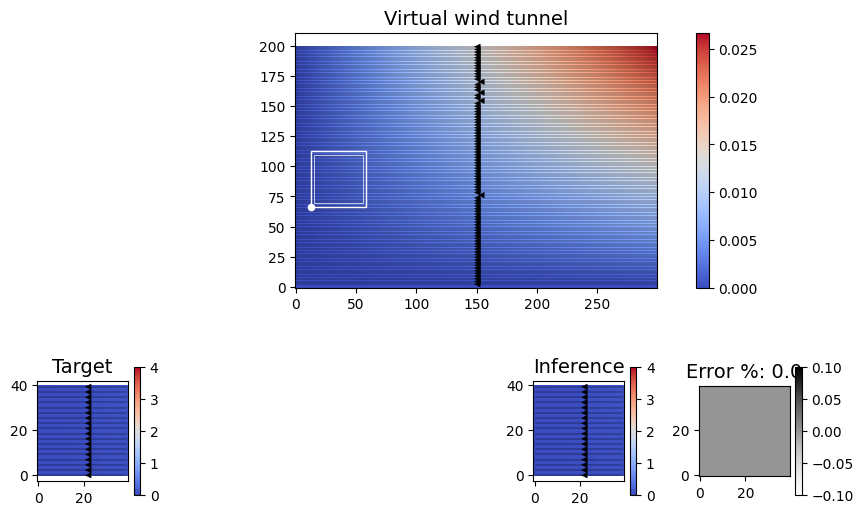

In [276]:
plt = new_test_env.render(quantity=np.abs(divergence[0,:,:]),
                          camera_position=camera_position,
                          c='white',
                          s=20,
                          lw=1,
                          normalize_cbars=True,
                          cmap='coolwarm',
                          add_streamplot=True,
                          streamplot_density=3,
                          streamplot_color='k',
                          streamplot_linewidth=0.3,
                          figsize=(10,6), 
                          filename=None);

We are going to take a number of steps in the test environment:

In [277]:
n_steps = 10

In [278]:
saved_camera_trajectories = np.zeros((n_steps,2))

In [288]:
camera_position, cues = new_test_env.reset(imposed_camera_position=(150,150))

In [289]:
for i in range(0,n_steps):

    saved_camera_trajectories[i, 0] = camera_position[0]
    saved_camera_trajectories[i, 1] = camera_position[1]

    cues = np.transpose(cues, (0, 2, 3, 1))
    cues[:,1,:,:] = -cues[:,1,:,:]

    q_values = ca.q_network(cues, training=False)

    action = np.argmax(q_values)

    print(new_test_env.action_to_verbose_direction[action])

    camera_position, cues, reward = new_test_env.step(action=action,
                                                  reward_function=reward_function,
                                                  reward_transformation=reward_transformation,
                                                  magnify_step=10,
                                                  verbose=False)

    print(camera_position)

Left
[150 140]
Left
[150 130]
Left
[150 120]
Left
[150 110]
Left
[150 100]
Left
[150  90]
Left
[150  80]
Left
[150  70]
Left
[150  60]
Left
[150  50]


The figure below visualizes the camera trajectory that results from the learned policy. 
Note that the agent correctly moves the camera towards the region of highest divergence.

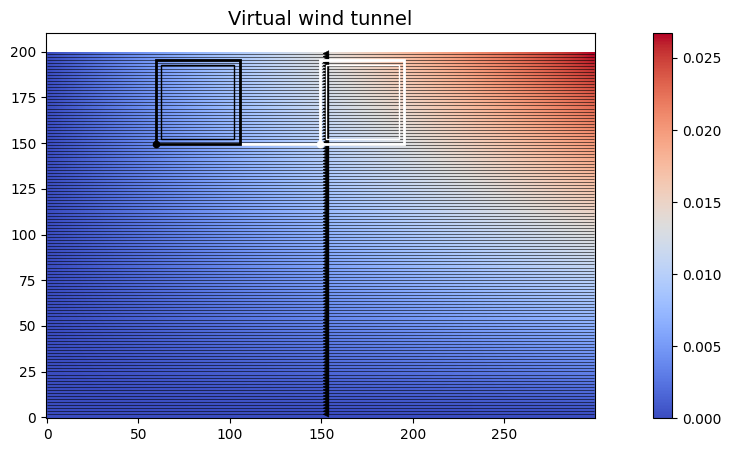

In [290]:
if save_images: filename='test-trajectory.png'
plot_trajectory(saved_camera_trajectories,
                quantity=np.abs(divergence[0,:,:]),
                vector_field=new_test_env.flowfield.velocity_field,
                interrogation_window_size=interrogation_window_size,
                interrogation_window_size_buffer=interrogation_window_size_buffer,
                c_path='white',
                c_init='white',
                c_final='black',
                s=20,
                lw=2,
                xlabel=None,
                ylabel=None,
                xticks=True,
                yticks=True,
                cmap='coolwarm',
                add_streamplot=True,
                streamplot_density=4,
                streamplot_color='k',
                streamplot_linewidth=0.4,
                figsize=(15,5),
                dpi=300,
                filename=filename);

Create sparse samples of camera position on a uniform grid:

In [282]:
(_, _, H, W) = new_test_env.flowfield.velocity_field_magnitude.shape
(H_adm, W_adm) = new_test_env.admissible_observation_space
idx_H = [i for i in range(0, H_adm) if i % 2 == 0]
idx_W = [i for i in range(0, W_adm) if i % 2 == 0]
print(len(idx_H) * len(idx_W))

9779


In [283]:
tic = time.perf_counter()

learned_policy = np.ones((H,W)) * np.nan

for h in idx_H:
    for w in idx_W:

        camera_position = np.array([h, w])
        _, cues = new_test_env.reset(imposed_camera_position=camera_position)
    
        cues = np.transpose(cues, (0, 2, 3, 1))
        cues[:,1,:,:] = -cues[:,1,:,:]    
        q_values = ca.q_network(cues, training=False)

        action = np.argmax(q_values)
        learned_policy[h, w] = action

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic)/60:0.1f} min.')

	Time it took: 0.9 min.


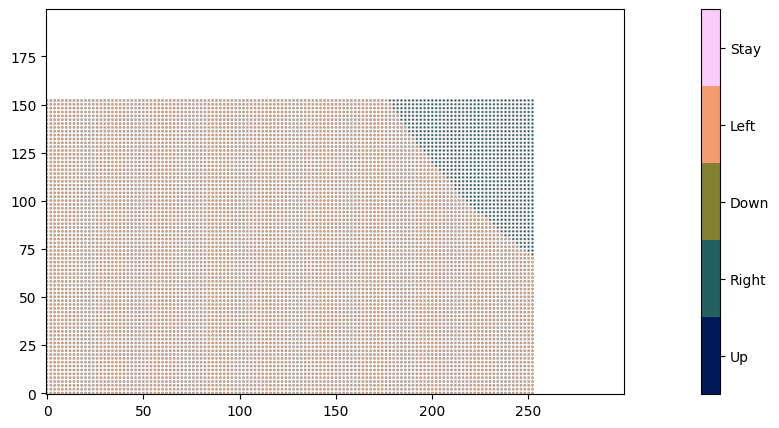

In [284]:
plt.figure(figsize=(20,5))
plt.imshow(learned_policy, origin='lower', cmap=cmap_actions, vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.set_ticks([4/5*(i+0.5) for i in range(0,5)])
cbar.set_ticklabels(list(new_test_env.action_to_verbose_direction.values()))

***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)